In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [17]:
(train_ds, test_ds,valid_ds), info = tfds.load(
    "kitti",
    split=['train','test', 'validation'],
    as_supervised=False,
    with_info=True,
    download = True,
)

In [18]:
info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_dir='/root/tensorflow_datasets/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'alpha': float32,


In [19]:
occluded_labels = info.features['objects']['occluded'].names
type_labels = info.features['objects']['type'].names

print("Occluded labels:", occluded_labels)
print("Type labels:", type_labels)
print("Number of classes:", len(occluded_labels) , len(type_labels))
print(np.unique(type_labels))

Occluded labels: ['fully visible', 'partly occluded', 'largely occluded', 'unknown']
Type labels: ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']
Number of classes: 4 8
['Car' 'Cyclist' 'Misc' 'Pedestrian' 'Person_sitting' 'Tram' 'Truck' 'Van']


In [20]:
import random
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [21]:
# Define model structure
model = tf.keras.Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg",
)

# Freeze layers of pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False


model.add(pretrained_model)
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="softmax"))

In [22]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs.get('val_accuracy')>=0.90:
            self.model.stop_training = True

In [24]:
# Function to ensure labels are correctly formatted as single integers
def preprocess_image(data):
    image = data.get("image")
    labels = data.get("objects")["occluded"]

    if image is None or labels is None:
        raise ValueError("Image or labels are None")

    # Resize image
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)

    # Ensure label is a single integer
    label = labels[0] if len(labels.shape) > 0 else labels

    return image, label
# Apply preprocessing, batch, and prefetch to datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
# calling callback
callback = CustomCallback()
# Fit the model
r = model.fit(train_ds, epochs=10, validation_data=valid_ds,callbacks=[callback])

Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 162s 727ms/step - accuracy: 0.7869 - loss: 0.9693 - val_accuracy: 0.8865 - val_loss: 0.2780
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 161s 792ms/step - accuracy: 0.8572 - loss: 0.4362 - val_accuracy: 0.8865 - val_loss: 0.2889
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 218s 876ms/step - accuracy: 0.8744 - loss: 0.3637 - val_accuracy: 0.8889 - val_loss: 0.2981
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 704ms/step - accuracy: 0.8855 - loss: 0.3167 - val_accuracy: 0.8842 - val_loss: 0.3203
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 702ms/step - accuracy: 0.8973 - loss: 0.2874 - val_accuracy: 0.8913 - val_loss: 0.3615
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 200s 698ms/step - accuracy: 0.9055 - loss: 0.2654 - val_accuracy: 0.8889 - val_loss: 0.3688
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 139s 680ms/step - accuracy: 0.9140 - loss: 0.2416 - val_accuracy: 0.8747 - val_loss: 0.4088
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 140s 696ms/step - accuracy: 0.9251 -

In [25]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - accuracy: 0.9469 - loss: 0.2503
Test accuracy: 94.66%


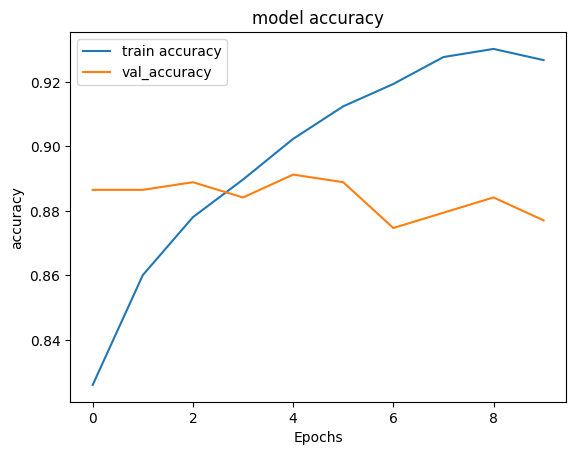

In [26]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.legend(["train accuracy","val_accuracy"])
plt.show()

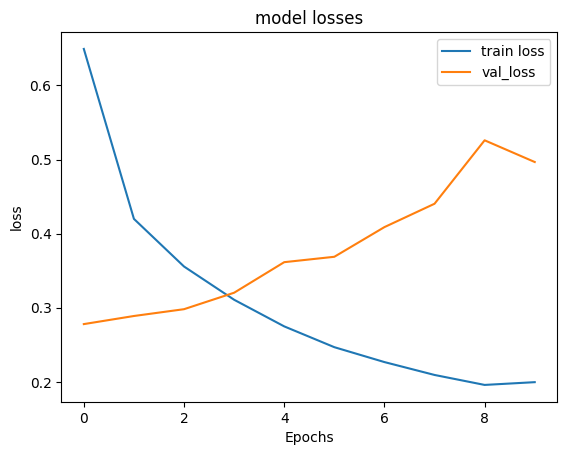

In [27]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('model losses')
plt.legend(["train loss","val_loss"])
plt.show()

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite','wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpmttfqxwh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_356')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137906140106240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906140111344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906140110816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906140107296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906140106416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906140114864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906116440688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906070219136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906103557584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137906103558288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379061035